<a href="https://colab.research.google.com/github/Spocklight/Fake_News_Detection/blob/master/Master_Algoritmos_NoNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Detección de noticias falsas</center></h1>
<h3><center>Alejandro Sierra Fernández</center></h3>
<h4><center>01/08/2022</center></h4>

*   <h2>Aplicación de algoritmos no neuronales</h2>

<font color='darkblue'> En este Notebook exploraremos el desempeño que tienen sobres nuestros datos los algoritmos conocidos como 'Support Vector Classifier' (SVC), Regresión Logística, 'K-nearest-neighbours' (KNN), Árboles de decisión, 'Random Forest' y Naive Bayes.   </font>

<font color='darkblue'>Comenzamos cargando los datos e importando las librerías que vamos a emplear: </n>

In [ ]:
from google.colab import drive
import warnings 
import pickle  
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier



In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Fake_News/'
pickle_in = open(path + 'ISOT_topic_sentiment_pickle', 'rb')
ISOT = pickle.load(pickle_in)

Mounted at /content/drive


In [ ]:
display(ISOT.dtypes)

title                           object
text                            object
subject                         object
date                    datetime64[ns]
normaliza_text                  object
normaliza_title                 object
clean_text                      object
clean_title                     object
char_len_title                   int64
char_len_text                    int64
char_len_title_t                 int64
char_len_text_t                  int64
token_text_len                   int64
token_title_len                  int64
prop_uppercase_text            float64
prop_uppercase_title           float64
prop_long_text                 float64
prop_long_title                float64
target                          object
normaliza_b_filter              object
topic_modelling                 object
topic_modelling_max              int64
Sentimiento_text               float64
Subjetividad_text              float64
Análisis_text                    int64
Sentimiento_title        

<font color='darkblue'>Dividimos nuestros datos en train y test. </n>

In [ ]:
train, test = train_test_split(ISOT, test_size=0.2, random_state=25)
print(train.shape)
print(test.shape)

(30607, 28)
(7652, 28)


<font color='darkblue'>Tratamos ahora el desequilibrio que pueda existir con respecto a la variable *target*. En este caso hacemos un Random-Under-Sampling manualmente, que consiste en quedarnos con un set de train balanceado, eliminando aleatoriamente instancias pertenecientes a la clase mayoritaria. Existen otras formas de afrontar este problema, pero es importante aplicar algún método. En el caso de no hacerlo nuestro modelo caería en la trampa métrica, que consiste la tendencia a predecir las instancias como pertenecientes a la clase mayoritaria para así aumentar el accuracy lo máximo posible. Esto nos dificultaría detectar elementos pertenecientes a la clase minoritaria, que con mucha frecuencia es el objeto de estudio y cuya identificación es la que motiva realmente la fabricación del modelo.</n>

In [ ]:
train['target'].value_counts()

True    16694
Fake    13913
Name: target, dtype: int64

In [ ]:
test['target'].value_counts()

True    4126
Fake    3526
Name: target, dtype: int64

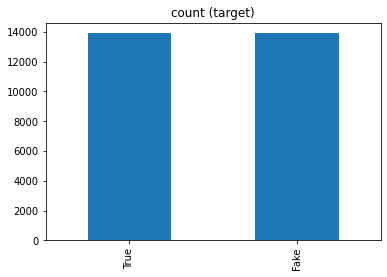

In [ ]:
count_1, count_0 = train["target"].value_counts()

class_0 = train[train.target=='Fake']
class_1 = train[train.target=='True']
class_1_under = class_1.sample(count_0)
train_under = pd.concat([class_1_under, class_0], axis=0)

train_under['target'].value_counts().plot(kind='bar', title='count (target)')
train_under['target'].value_counts()
train = train_under

In [ ]:
train['target'].value_counts()

True    13913
Fake    13913
Name: target, dtype: int64

<font color='darkblue'> Transformamos ahora nuestra variable *target* para convertirla en variable numérica.

In [ ]:
train["target"] = (train['target'] == 'True').astype(np.float32)  #True=1, Fake=0
test["target"] = (test['target'] == 'True').astype(np.float32)  #True=1, Fake=0

<font color='darkblue'> En el siguiente bloque de código transformamos nuestras noticias y nuestros títulos en un formato numérico que pueda ser pasado al modelo como input. La idea es representar nuestros textos en un espacio vectorial n-dimensional. Para ello empleamos la técnica TF-IDF:</n>

In [ ]:
vectorizador = TfidfVectorizer(max_features=100,                  
                               ngram_range=(1,3),
                               min_df=10,
                               max_df=0.50,
                               lowercase=False)

vector_title_train = vectorizador.fit_transform(train["clean_title"])
vector_text_train = vectorizador.fit_transform(train["clean_text"])
vector_title_test = vectorizador.fit_transform(test["clean_title"])
vector_text_test = vectorizador.fit_transform(test["clean_text"])

<font color='darkblue'> A continuación, normalizamos aquellas variables que habíamos obtenido durante el preprocesado de la información. No lo hacemos con los vectores que surgen del *TfidVectorizer* porque estaríamos modificando los pesos asociados a cada una de las palabras que describen nuestro dataset de noticias, y por tanto, modificando la representación de las mismas. </n>

<font color='darkblue'> La técnica TF-IDF asocia pesos más pequeños a términos más frecuentes y pesos más grandes a términos menos frecuentes. Al modificar estos datos con la normalización, estaríamos distorsionando la representación de la información original.  </n>

<font color='darkblue'>Podemos encontrar más información sobre el tema en el siguiente enlace: 

https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features </n>




In [ ]:
extra_features_train_d = train[['Sentimiento_text', 'Análisis_text', 'Subjetividad_text', 'Sentimiento_title', 'Análisis_title', 'Subjetividad_title', 'topic_modelling_max',
                              'prop_long_text', 'prop_long_title', 'prop_uppercase_text', 'prop_uppercase_title', 'token_title_len', 'token_text_len',
                              'char_len_title', 'char_len_text']]

extra_features_test_d = test[['Sentimiento_text', 'Análisis_text', 'Subjetividad_text', 'Sentimiento_title', 'Análisis_title', 'Subjetividad_title', 'topic_modelling_max',
                              'prop_long_text', 'prop_long_title', 'prop_uppercase_text', 'prop_uppercase_title', 'token_title_len', 'token_text_len',
                              'char_len_title', 'char_len_text']]

sc = StandardScaler()
extra_features_train = sc.fit_transform(extra_features_train_d)
extra_features_test = sc.transform(extra_features_test_d)

<font color='darkblue'> Con scipy.sparse.hstack unimos las variables con los vectores del TF-IDF tanto en el set de train como en el de test. Tenemos algunas variables que están definidas tanto para los títulos y las noticias originales como para las preprocesadas. Hemos decidido quedarnos con aquellas que mostraban una distribución más diferente para los sets *true* y *fake*, esto en función de las gráficas obtenidas anteriormente </n>

In [ ]:
y_train = train["target"].values
X_train_text = sp.sparse.hstack((vector_text_train, extra_features_train),format='csr')
X_train_title = sp.sparse.hstack((vector_title_train, extra_features_train),format='csr')

y_test = test["target"].values
X_test_text = sp.sparse.hstack((vector_text_test, extra_features_test),format='csr')
X_test_title = sp.sparse.hstack((vector_title_test, extra_features_test),format='csr')

In [ ]:
X_columns_text=vectorizador.get_feature_names()+extra_features_train_d.columns.tolist()
display(X_columns_text)
len(X_columns_text)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['administration',
 'also',
 'american',
 'ask',
 'attack',
 'back',
 'bill',
 'call',
 'campaign',
 'clinton',
 'come',
 'could',
 'country',
 'court',
 'day',
 'democratic',
 'donald',
 'donald trump',
 'election',
 'even',
 'first',
 'force',
 'former',
 'get',
 'give',
 'go',
 'government',
 'group',
 'help',
 'hillary',
 'house',
 'image',
 'include',
 'issue',
 'know',
 'last',
 'law',
 'leader',
 'leave',
 'like',
 'make',
 'man',
 'many',
 'may',
 'medium',
 'million',
 'month',
 'national',
 'need',
 'new',
 'news',
 'obama',
 'official',
 'one',
 'party',
 'people',
 'percent',
 'plan',
 'police',
 'policy',
 'political',
 'presidential',
 'report',
 'republican',
 'reuters',
 'right',
 'russia',
 'security',
 'see',
 'senate',
 'show',
 'since',
 'state',
 'statement',
 'states',
 'support',
 'take',
 'talk',
 'tell',
 'think',
 'time',
 'trump',
 'try',
 'two',
 'united',
 'united states',
 'use',
 'via',
 'vote',
 'want',
 'washington',
 'way',
 'we',
 'week',
 'well',
 'w

115

In [ ]:
X_train_text = X_train_text.toarray()
X_train_title = X_train_title.toarray()
X_test_text = X_test_text.toarray()
X_test_title = X_test_title.toarray()


<font color='darkblue'> Definimos ahora una función para obtener la precisión de los modelos sin realizarles *tunin* o ajuste de parámetros.   </n>

In [ ]:
def model_evaluation(models, score, X, y):
    results = []
    names = []
      
    for name, model in models:

        warnings.filterwarnings('ignore') 
        KF = KFold(n_splits = 10, shuffle = True, random_state = 98) 
        cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)
        results.append(cv_results)
        names.append(name)
        print('Metric: {} , KFold '.format(str(score)), "\n")
        print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()), "\n")
    
    return results, names

In [ ]:
def model_evaluation(models, score, X, y):
    results = []
    names = []
     
    pbar = tqdm(total=len(models)) 

    for name, model in models:

        warnings.filterwarnings('ignore') 
        KF = KFold(n_splits = 10, shuffle = True, random_state = 98) 
        cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)
        results.append(cv_results)
        names.append(name)
        print('Metric: {} , KFold '.format(str(score)), "\n")
        print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()), "\n")
        pbar.update(1)
    
    return results, names
    pbar.close()

In [ ]:
models = [
          ("Logistic", LogisticRegression(random_state=30)),
          ("GaussianNB", GaussianNB()),
          ("SVM", SVC(random_state=30)),
          ("KNN", KNeighborsClassifier()),
          ("DTC", tree.DecisionTreeClassifier(random_state=30)),
          ("RF", RandomForestClassifier(random_state=30))
]

evaluation_score = "accuracy"
model_evaluation(models,  evaluation_score, X_train_text, y_train) 

 14%|█▍        | 1/7 [00:08<00:50,  8.35s/it]

Metric: accuracy , KFold  

Logistic: 0.995184 (0.001664)  



 29%|██▊       | 2/7 [00:36<01:39, 20.00s/it]

Metric: accuracy , KFold  

DecisionTree: 0.990405 (0.001464)  



 43%|████▎     | 3/7 [00:37<00:45, 11.28s/it]

Metric: accuracy , KFold  

GaussianNB: 0.974412 (0.001765)  



 57%|█████▋    | 4/7 [01:42<01:37, 32.53s/it]

Metric: accuracy , KFold  

SVC: 0.995616 (0.001051)  



 71%|███████▏  | 5/7 [02:02<00:55, 27.87s/it]

Metric: accuracy , KFold  

KNN: 0.972436 (0.002251)  



 86%|████████▌ | 6/7 [02:28<00:27, 27.36s/it]

Metric: accuracy , KFold  

clf: 0.990405 (0.001464)  



100%|██████████| 7/7 [04:01<00:00, 34.49s/it]

Metric: accuracy , KFold  

RF: 0.995723 (0.000915)  



([array([0.99568811, 0.99676608, 0.99353216, 0.99245419, 0.99604743,
         0.99317284, 0.99748382, 0.99640546, 0.99640546, 0.99388929]),
  array([0.98814229, 0.98922027, 0.99209486, 0.99137621, 0.98993891,
         0.98814229, 0.99209202, 0.99065421, 0.99029475, 0.99209202]),
  array([0.97700323, 0.97664391, 0.97089472, 0.97412864, 0.97197269,
         0.97412864, 0.97483825, 0.97447879, 0.97483825, 0.9751977 ]),
  array([0.99353216, 0.9971254 , 0.99604743, 0.99532878, 0.99604743,
         0.99461013, 0.99712437, 0.99496765, 0.99604601, 0.9953271 ]),
  array([0.96802012, 0.97305066, 0.97125404, 0.97340999, 0.97340999,
         0.97664391, 0.97016535, 0.97196262, 0.97196262, 0.97447879]),
  array([0.98814229, 0.98922027, 0.99209486, 0.99137621, 0.98993891,
         0.98814229, 0.99209202, 0.99065421, 0.99029475, 0.99209202]),
  array([0.99568811, 0.99496946, 0.99676608, 0.99496946, 0.99604743,
         0.99461013, 0.99640546, 0.99748382, 0.9946082 , 0.99568656])],
 ['Logistic', 'Deci

In [ ]:
model = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

random_grid = {'max_depth': [5, 10, 15, 20],
               'criterion' :['gini', 'entropy'],
               'n_estimators': [100, 250, 500]}

cv = KFold(n_splits=5)
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter = 100, cv = cv, verbose=10, random_state=42)

In [ ]:
grid_result = rf_random.fit(X_train_text, y_train)

In [ ]:
pprint(grid_result.best_estimator_.get_params())
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", grid_result.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_result.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_result.best_params_)


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=20, n_estimators=500)

 The best score across ALL searched params:
 0.9938546282315392

 The best parameters across ALL searched params:
 {'n_estimators': 500, 'max_depth': 20, 'criterion': 'gini'}


In [ ]:
RF_tuned=RandomForestClassifier(criterion = 'gini', max_depth = 20, n_estimators = 500)
RF_tuned.fit(X_train_text,y_train)

RandomForestClassifier(max_depth=20, n_estimators=500)

In [ ]:
y_pred = RF_tuned.predict(X_test_text)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[3471   55]
 [  75 4051]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3526
         1.0       0.99      0.98      0.98      4126

    accuracy                           0.98      7652
   macro avg       0.98      0.98      0.98      7652
weighted avg       0.98      0.98      0.98      7652



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


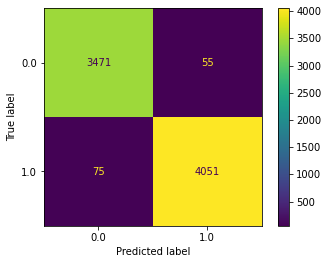

In [ ]:
plot_confusion_matrix(RF_tuned, X_test_text, y_test, normalize = None)

Feature: 0, Name: administration , Score: 0.00040
Feature: 1, Name: also , Score: 0.00048
Feature: 2, Name: american , Score: 0.00059
Feature: 3, Name: ask , Score: 0.00142
Feature: 4, Name: attack , Score: 0.00037
Feature: 5, Name: back , Score: 0.00042
Feature: 6, Name: bill , Score: 0.00040
Feature: 7, Name: call , Score: 0.00026
Feature: 8, Name: campaign , Score: 0.00048
Feature: 9, Name: clinton , Score: 0.00045
Feature: 10, Name: come , Score: 0.00117
Feature: 11, Name: could , Score: 0.00052
Feature: 12, Name: country , Score: 0.00076
Feature: 13, Name: court , Score: 0.00085
Feature: 14, Name: day , Score: 0.00037
Feature: 15, Name: democratic , Score: 0.00042
Feature: 16, Name: donald , Score: 0.00086
Feature: 17, Name: donald trump , Score: 0.00149
Feature: 18, Name: election , Score: 0.00126
Feature: 19, Name: even , Score: 0.00074
Feature: 20, Name: first , Score: 0.00883
Feature: 21, Name: force , Score: 0.00050
Feature: 22, Name: former , Score: 0.00122
Feature: 23, Name

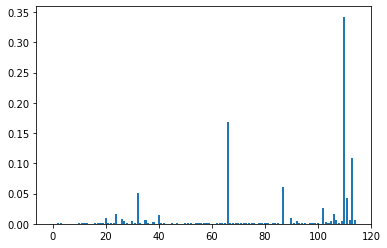

In [ ]:
importance = RF_tuned.feature_importances_

for i,v in enumerate(importance):
 print('Feature: %0d, Name: %s , Score: %.5f' % (i,X_columns_text[i],v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
model = SVC()

SVM_param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

cv = KFold(n_splits=5)
rf_random = RandomizedSearchCV(estimator=model, param_distributions=SVM_param_grid, n_iter = 100, cv = cv, verbose=10, random_state=42)

In [ ]:
grid_result = rf_random.fit(X_train_text, y_train)

In [ ]:
pprint(grid_result.best_estimator_.get_params())
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", grid_result.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_result.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_result.best_params_)

{'C': 1000,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.001,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}
 Results from Random Search 

 The best estimator across ALL searched params:
 SVC(C=1000, gamma=0.001)

 The best score across ALL searched params:
 0.9956874865011193

 The best parameters across ALL searched params:
 {'kernel': 'rbf', 'gamma': 0.001, 'C': 1000}


In [ ]:
SVM_tuned=SVC(C=1000, gamma = 0.001, kernel = 'rbf')
SVM_tuned.fit(X_train_text,y_train)

SVC(C=1000, gamma=0.001)

In [ ]:
y_pred = SVM_tuned.predict(X_test_text)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[3447   79]
 [  76 4050]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3526
         1.0       0.98      0.98      0.98      4126

    accuracy                           0.98      7652
   macro avg       0.98      0.98      0.98      7652
weighted avg       0.98      0.98      0.98      7652



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


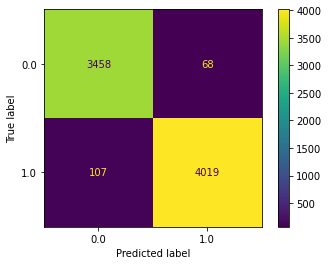

In [ ]:
plot_confusion_matrix(SVM_tuned, X_test_text, y_test, normalize = None)

In [ ]:
from numpy import savetxt
savetxt('data_test_MF.csv', X_test_text, delimiter=',')
savetxt('X_train_MF.csv', X_train_text, delimiter=',')
savetxt('y__train_MF.csv', y_train, delimiter=',')
savetxt('y__test_MF.csv', y_test, delimiter=',')

In [ ]:
path = '/content/drive/MyDrive/Fake_News/'
pickle_out = open(path + 'model_RF_Tuned', 'wb')
pickle.dump(ISOT, pickle_out)

In [ ]:
path = '/content/drive/MyDrive/Fake_News/'
pickle_out = open(path + 'ISOT_pickle', 'wb')
pickle.dump(ISOT, pickle_out)
pickle_out.close()